# Kantorovich Primal formulation of OT
$$L_C(a,b) = \min_{P\in U(a,b)} \sum_{i\in [\![n]\!], j \in [\![m]\!]} C_{i,j} P_{i,j}$$

Which we can rewrite as :
$$L_C(a,b) = \min_{p \in R^{nm}_{+} \\ Ap = \begin{bmatrix}a \\ b\end{bmatrix}} c^T p$$

With :
$$A = \begin{bmatrix}
        \mathbb{1}_n^T \otimes \mathbb{I}_m \\
        \mathbb{I}_n \otimes \mathbb{1}_m^T \\
      \end{bmatrix}$$
Which encodes :
$$P \mathbb{1}_n = a$$
$$P^T \mathbb{1}_m = b$$

In [1]:
import matplotlib.pyplot as plt 
from sklearn.datasets import make_moons, make_circles
from scipy.spatial import distance_matrix
import numpy as np

from cvxopt import matrix, solvers
%matplotlib inline

We generate two distributions of points $a$ and $b$ and compute their distances

In [2]:
n = 25
m = 25
np.random.seed(42)
moons, mclass = make_circles(max(n,m)*2, noise = 0.15, factor=0.6, random_state=42)
#moons, mclass = make_moons(max(n,m)*2, noise = 0.15)

axy = moons[mclass==0][:n]
a = np.random.rand(n, 1)
a = a/np.sum(a)

bxy = moons[mclass==1][:m]
b = np.random.rand(m, 1)
b = b/np.sum(b)

Here the distributions of point we generated
(a point is displayed as a circle of radius $\sqrt{w}$, so that its area $\approx$ it's weight) :

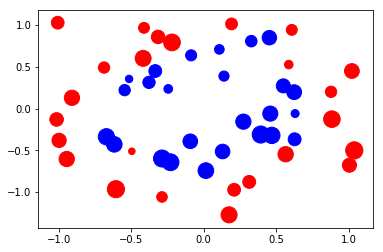

In [3]:
plt.scatter(axy[:,0], axy[:,1], s = a**(1/2)*1000, c="red")
plt.scatter(bxy[:,0], bxy[:,1], s = b**(1/2)*1000, c="blue")

We compute the distance matrix $C$ and the distance vector $c$

In [4]:
C = distance_matrix(axy, bxy, p=2)
C = C**2
c = C.T.reshape(-1)
c = matrix(c)

We build the matrix that encode the coupling constraint 

We need to remove a row from $A$ and from the vector of distributions, because else the system wouldn't be free

In [5]:
In = np.eye(n)
Im = np.eye(m)
Onesn = np.matrix([1] * n)
Onesm = np.matrix([1] * m)
A = np.concatenate([np.kron(Onesn, Im),
                    np.kron(In, Onesm)], axis=0)
A = matrix(A[1:])

dists = np.concatenate([a[1:], b], axis=0)
dists = matrix(dists)

We encode the positivity of coefficients

In [6]:
G = -np.eye(n*m)
G = matrix(G)
h = np.zeros((n*m,))
h = matrix(h)

We solve the linear programming using *cvxopt*

In [7]:
sols = solvers.lp(c, G, h, A, dists)

     pcost       dcost       gap    pres   dres   k/t
 0:  1.4632e+00  1.4632e+00  2e+03  3e+01  2e+00  1e+00
 1: -1.4659e+00 -1.4809e+00  5e+01  6e-01  4e-02  1e-02
 2: -1.3099e-01 -1.3152e-01  2e+00  5e-02  4e-03  2e-03
 3:  9.8618e-02  9.8629e-02  1e+00  3e-02  2e-03  1e-03
 4:  2.6659e-01  2.6664e-01  5e-01  1e-02  9e-04  6e-04
 5:  2.9353e-01  2.9361e-01  3e-01  7e-03  5e-04  4e-04
 6:  3.3039e-01  3.3041e-01  6e-02  2e-03  1e-04  9e-05
 7:  3.3597e-01  3.3598e-01  2e-02  6e-04  4e-05  3e-05
 8:  3.3766e-01  3.3767e-01  6e-03  2e-04  1e-05  1e-05
 9:  3.3811e-01  3.3811e-01  2e-03  7e-05  5e-06  4e-06
10:  3.3836e-01  3.3836e-01  1e-04  4e-06  3e-07  2e-07
11:  3.3837e-01  3.3837e-01  1e-06  4e-08  3e-09  2e-09
12:  3.3837e-01  3.3837e-01  1e-08  4e-10  3e-11  2e-11
Optimal solution found.


In [8]:
p = np.array(sols["x"])
#p[p < 1e-10] = 0

In [12]:
#c = np.array(c)
#cost = c.T.dot(p)
cost = np.sum(np.multiply(C,P))
print(f"Total cost : {cost}")

Total cost : 0.3383699950368827


In [9]:
P = p.reshape(m, n).T

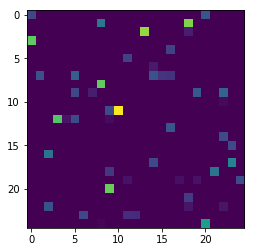

In [11]:
import matplotlib.pyplot as plt
plt.imshow(P)

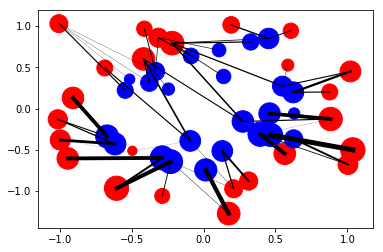

In [13]:
plt.scatter(axy[:,0], axy[:,1], s = a**(1/2)*2000, c="red")
plt.scatter(bxy[:,0], bxy[:,1], s = b**(1/2)*2000, c="blue")
maxP = np.max(P)
for i in range(n):
    for j in range(m):
        plt.plot([axy[i,0], bxy[j,0]], [axy[i,1], bxy[j,1]], linewidth=P[i,j]*5/maxP, linestyle="-", c="black")

In [14]:
print(np.sum(P, axis=1) - a.reshape(-1))
print(np.sum(P, axis=0) - b.reshape(-1))

[-4.99600361e-16  4.85722573e-16 -2.35922393e-16 -6.24500451e-17
 -2.08166817e-17 -3.81639165e-17  0.00000000e+00 -1.38777878e-17
 -1.04083409e-16 -4.16333634e-17  2.16840434e-19 -5.55111512e-17
 -3.33066907e-16  2.42861287e-17 -3.46944695e-18  1.38777878e-17
  2.77555756e-17  1.59594560e-16 -3.46944695e-17  1.73472348e-17
 -1.80411242e-16  5.20417043e-18 -1.04083409e-17 -9.71445147e-17
 -2.77555756e-17]
[-1.38777878e-17 -3.46944695e-17  2.08166817e-17  4.16333634e-17
  1.73472348e-18  1.24900090e-16  3.64291930e-17 -2.60208521e-18
 -1.24900090e-15 -3.60822483e-16  5.55111512e-17 -5.55111512e-17
 -5.20417043e-18  3.53883589e-16 -4.16333634e-17  1.73472348e-18
 -6.93889390e-17  1.73472348e-18 -2.91433544e-16  5.89805982e-17
 -1.38777878e-17  9.36750677e-17  0.00000000e+00  1.11022302e-16
 -6.93889390e-18]


In [15]:
a = a.reshape(-1)
b = b.reshape(-1)
fg = np.array(sols["y"])
P[np.abs(P) < 1e-10] = 0
fg[np.abs(fg) < 1e-10] = 0
f = np.zeros((n,))
g = np.zeros((m,))

f[1:] = -fg[:n-1].reshape(-1)
g = -fg[n-1:].reshape(-1)

In [16]:
f

array([ 0.        , -0.41378972, -0.09986422,  0.11358979, -0.02310073,
        0.61497023, -0.39524938,  0.39771436, -0.21910144,  0.306009  ,
       -0.6113292 , -0.19599556, -0.37314231,  0.03948615,  0.34629321,
       -0.36488925, -0.40928974, -0.20697238, -0.1392326 ,  1.1282038 ,
       -0.56213074, -0.48303721, -0.35889657,  0.50850561, -0.10001594])

In [17]:
g

array([ 0.16057569, -0.09905565,  0.57563596,  0.55752725,  0.44183694,
        0.74589207, -0.40782942, -0.1420905 ,  0.65007867,  0.64740837,
        0.55124437, -0.34104316, -0.30791014,  0.40608488,  0.46185957,
       -0.10634605,  0.0556884 , -0.43230124,  0.65955894, -0.22165968,
        0.24677705,  0.37808443,  0.78756038,  0.42947703, -0.26230612])